In [1]:
import src.helper as hp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, r2_score, recall_score
from sklearn.model_selection import GridSearchCV

In [2]:
# Get data 
driver = hp.get_data('data/churn.csv')

In [3]:
driver['phone'].value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

In [4]:
X, y = hp.data_clean('data/churn_train.csv')

In [5]:
X.drop('service_age', axis=1, inplace=True)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [10]:
def get_model_errors(model, X, y):
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    return accuracy, precision, recall

In [11]:
model = RandomForestClassifier()
model.fit(X_train, y_train)


RandomForestClassifier()

In [12]:
y_pred = model.predict(X_test)

In [13]:
y_pred.mean()

0.5335

In [14]:
(y_pred==y_test).mean()

0.7795

In [15]:
accuracy, precision, recall = get_model_errors(model, X_test, y_test)
print(accuracy, precision, recall)

0.7795 0.7825679475164011 0.7998084291187739


In [17]:
k = 10 # number of folds in the cross-validation 
scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=k, n_jobs=-1) 
scores.mean()

0.7740333333333334

In [18]:
model.feature_importances_

array([0.15585476, 0.10305044, 0.06204331, 0.04848129, 0.02048371,
       0.06167982, 0.10087362, 0.02139309, 0.11434056, 0.01110003,
       0.02412011, 0.00966198, 0.14670951, 0.12020778, 0.        ])


13. Feature ranking:
1. avg_dist (0.155855)
2. weekday_pct (0.114341)
3. avg_rating_by_driver (0.103050)
4. trips_in_first_30_days (0.100874)
5. avg_rating_of_driver (0.062043)
6. surge_pct (0.061680)
7. avg_surge (0.048481)
8. luxury_car_user (0.021393)
9. is_iphone (0.020484)
10. city_Astapor (0.011100)


Text(0.5, 1.0, 'Feature Importances')

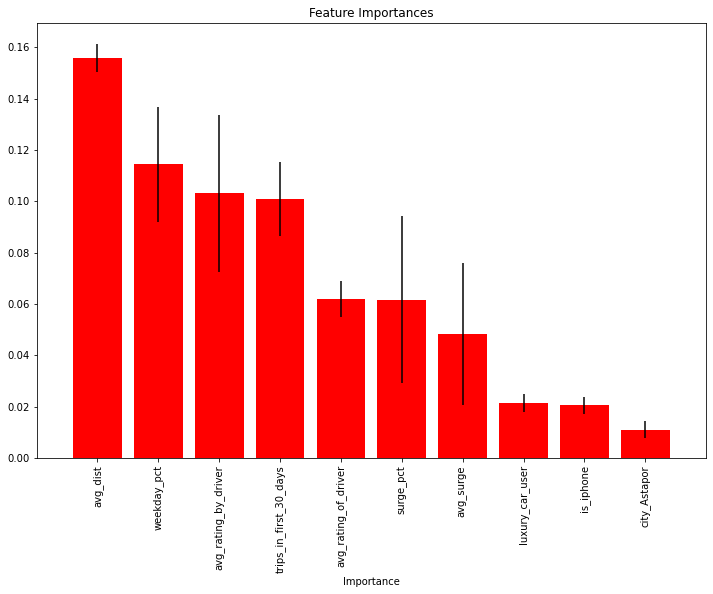

In [19]:
n = 10 # top 10 features

#importances = forest_fit.feature_importances_[:n]
importances = model.feature_importances_[:n]
std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
features = list(X.columns[indices])

# Print the feature ranking
print("\n13. Feature ranking:")

for f in range(n):
    print("%d. %s (%f)" % (f + 1, features[f], importances[indices[f]]))

# Plot the feature importances of the forest
fig, ax = plt.subplots(figsize=(12, 8))

ax.bar(range(10), importances[indices], yerr=std[indices], color="r", align="center")
ax.set_xticks(range(10))
ax.set_xticklabels(features, rotation = 90)
ax.set_xlim([-1, 10])
ax.set_xlabel("Importance")
ax.set_title("Feature Importances")

<AxesSubplot:>

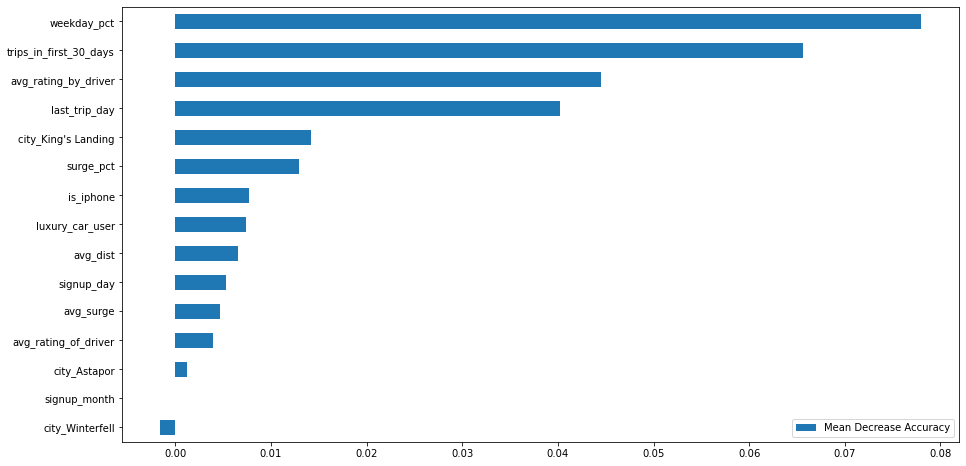

In [20]:
from sklearn.model_selection import ShuffleSplit
from collections import defaultdict


names = X.columns
 
rf = RandomForestClassifier()
scores = defaultdict(list)
 
# crossvalidate the scores on a number of 
# different random splits of the data
splitter = ShuffleSplit(100, test_size=.3)

for train_idx, test_idx in splitter.split(X, y):
    X_train, X_test = X.values[train_idx], X.values[test_idx]
    y_train, y_test = y.values[train_idx], y.values[test_idx]
    rf.fit(X_train, y_train)
    acc = accuracy_score(y_test, rf.predict(X_test))
    for i in range(X.shape[1]):
        X_t = X_test.copy()
        np.random.shuffle(X_t[:, i])
        shuff_acc = accuracy_score(y_test, rf.predict(X_t))
        scores[names[i]].append((acc-shuff_acc)/acc)

score_series = pd.DataFrame(scores).mean()
scores = pd.DataFrame({'Mean Decrease Accuracy' : score_series})
scores.sort_values(by='Mean Decrease Accuracy').plot(kind='barh', figsize=(15,8))

### Find Best Model

In [24]:
random_forest_grid = {'max_depth': [3, None],
                      'max_features': ['sqrt', 'log2', None],
                      'min_samples_split': [2, 4, 6],
                      'min_samples_leaf': [1, 2, 4],
                      'bootstrap': [True, False],
                      'n_estimators': [10, 20, 40, 80],
                      'random_state': [1]}
model_gridsearch = GridSearchCV(RandomForestClassifier(),
                                random_forest_grid,
                                n_jobs=-1,
                                verbose=True,
                                scoring='accuracy')
model_gridsearch.fit(X_train, y_train)
best_params = model_gridsearch.best_params_ 
model_best = model_gridsearch.best_estimator_



Fitting 5 folds for each of 432 candidates, totalling 2160 fits


In [25]:

accuracy, precision, recall = get_model_errors(model_best, X_test, y_test)
print(accuracy, precision, recall)

0.7819166666666667 0.7723491151111783 0.8211643615310389


In [26]:
best_params

{'bootstrap': True,
 'max_depth': None,
 'max_features': None,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 40,
 'random_state': 1}

In [27]:
random_forest_grid = {'max_depth': [3, None],
                      'max_features': ['sqrt', 'log2', None],
                      'min_samples_split': [1, 2, 4],
                      'min_samples_leaf': [2, 4,6],
                      'bootstrap': [True],
                      'random_state': [1]}
model_gridsearch = GridSearchCV(RandomForestClassifier(),
                                random_forest_grid,
                                n_jobs=-1,
                                verbose=True,
                                scoring='accuracy')
model_gridsearch.fit(X_train, y_train)
best_params = model_gridsearch.best_params_ 
model_best = model_gridsearch.best_estimator_

Fitting 5 folds for each of 54 candidates, totalling 270 fits


/Users/vinsonmccready/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.72789286 0.72789286        nan 0.72789286 0.72789286
        nan 0.72785714 0.72785714        nan 0.72789286 0.72789286
        nan 0.72789286 0.72789286        nan 0.72785714 0.72785714
        nan 0.71171429 0.71171429        nan 0.71171429 0.71171429
        nan 0.71171429 0.71171429        nan 0.77717857 0.77717857
        nan 0.77778571 0.77778571        nan 0.77571429 0.77571429
        nan 0.77717857 0.77717857        nan 0.77778571 0.77778571
        nan 0.77571429 0.77571429        nan 0.7825     0.7825
        nan 0.78457143 0.78457143        nan 0.784      0.784     ]
  warnings.warn(


In [28]:

accuracy, precision, recall = get_model_errors(model_best, X_test, y_test)
print(accuracy, precision, recall)
best_params

0.78425 0.7745498562566198 0.8232550659376006


{'bootstrap': True,
 'max_depth': None,
 'max_features': None,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'random_state': 1}


13. Feature ranking:
1. avg_rating_by_driver (0.216044)
2. weekday_pct (0.132550)
3. avg_dist (0.119109)
4. trips_in_first_30_days (0.108492)
5. avg_rating_of_driver (0.043169)
6. surge_pct (0.038816)
7. avg_surge (0.025434)
8. luxury_car_user (0.020751)
9. is_iphone (0.018357)
10. city_Astapor (0.007742)


Text(0.5, 1.0, 'Feature Importances')

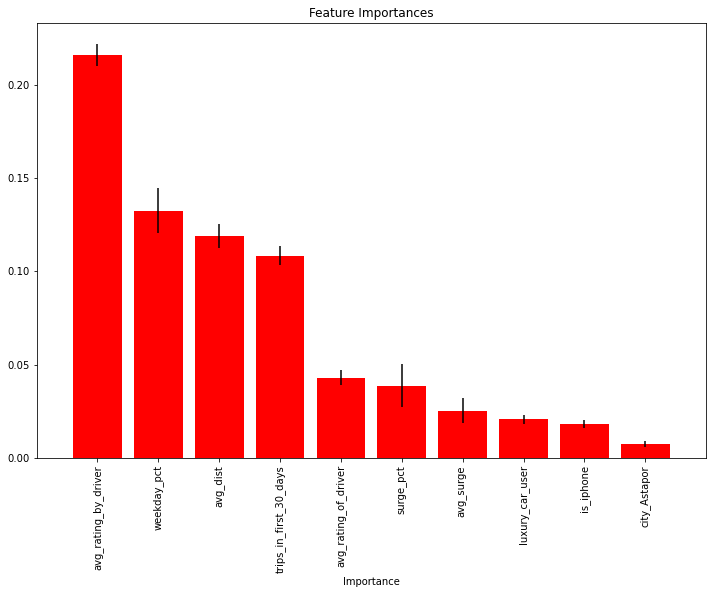

In [29]:
n = 10 # top 10 features

#importances = forest_fit.feature_importances_[:n]
importances = model_best.feature_importances_[:n]
std = np.std([tree.feature_importances_ for tree in model_best.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
features = list(X.columns[indices])

# Print the feature ranking
print("\n13. Feature ranking:")

for f in range(n):
    print("%d. %s (%f)" % (f + 1, features[f], importances[indices[f]]))

# Plot the feature importances of the forest
fig, ax = plt.subplots(figsize=(12, 8))

ax.bar(range(10), importances[indices], yerr=std[indices], color="r", align="center")
ax.set_xticks(range(10))
ax.set_xticklabels(features, rotation = 90)
ax.set_xlim([-1, 10])
ax.set_xlabel("Importance")
ax.set_title("Feature Importances")

<AxesSubplot:>

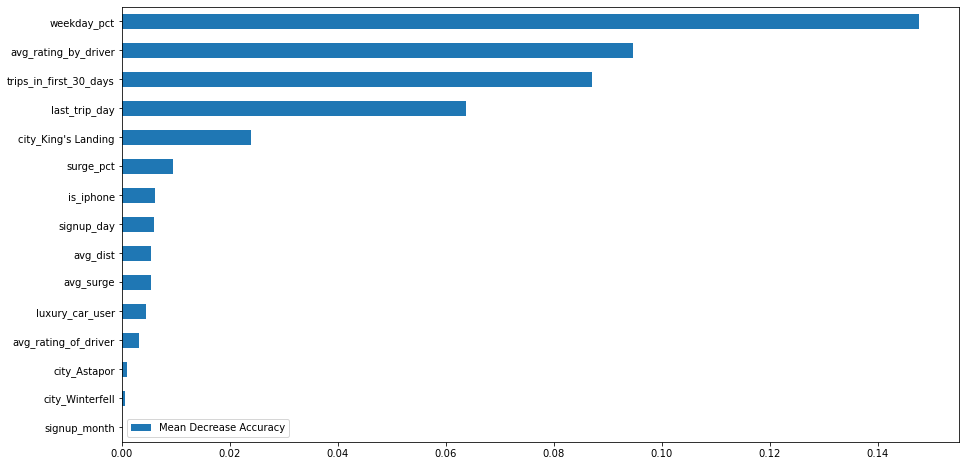

In [32]:
from sklearn.model_selection import ShuffleSplit
from collections import defaultdict


names = X.columns
 
rf = model_best
scores = defaultdict(list)
 
# crossvalidate the scores on a number of 
# different random splits of the data
splitter = ShuffleSplit(10, test_size=.3)

for train_idx, test_idx in splitter.split(X, y):
    X_train, X_test = X.values[train_idx], X.values[test_idx]
    y_train, y_test = y.values[train_idx], y.values[test_idx]
    rf.fit(X_train, y_train)
    acc = accuracy_score(y_test, rf.predict(X_test))
    for i in range(X.shape[1]):
        X_t = X_test.copy()
        np.random.shuffle(X_t[:, i])
        shuff_acc = accuracy_score(y_test, rf.predict(X_t))
        scores[names[i]].append((acc-shuff_acc)/acc)

score_series = pd.DataFrame(scores).mean()
scores = pd.DataFrame({'Mean Decrease Accuracy' : score_series})
scores.sort_values(by='Mean Decrease Accuracy').plot(kind='barh', figsize=(15,8))